In [1]:
from tensorflow.contrib.layers import flatten
from tensorflow.contrib.layers import xavier_initializer as init
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)


def conv_layer(input, shape, strides=(1, 1, 1, 1), name="conv"):
    with tf.variable_scope(name):
        w = tf.get_variable("w", shape=shape, initializer=init())
        b = tf.get_variable("b", shape=[shape[-1]], initializer=init())
        return tf.nn.elu(tf.nn.conv2d(input, w, strides, 'VALID') + b)


def fc_layer(input, shape, name="fc"):
    with tf.variable_scope(name):
        w = tf.get_variable("w", shape=shape, initializer=init())
        b = tf.get_variable("b", shape=[shape[-1]], initializer=init())
        return tf.add(tf.matmul(input, w), b)


def pool(input):
    return tf.nn.max_pool(input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

In [33]:
import cv2
import numpy as np
import os

folders = ['samples/basements/basement_0001a', 'samples/basements/basement_0001b', 'samples/basements/basement_0001c']

X_filenames = []
y_filenames = []

for folder in folders:
    files = os.listdir(folder)
    images = list(map(lambda x: folder + "/" + x, filter(lambda x: x.endswith('.ppm'), files)))
    depths = list(map(lambda x: folder + "/" + x, filter(lambda x: x.endswith('.pgm'), files)))
    
    if len(images) != len(depths):
        final_len = np.min([len(images), len(depths)])
        images = images[:final_len]
        depths = depths[:final_len]
    
    X_filenames += images
    y_filenames += depths

In [46]:
from sklearn.utils import shuffle


def batch_generator(X_filenames, y_filenames, batch_size=128):
    while 1:
        X_filenames, y_filenames = shuffle(X_filenames, y_filenames)
        for offset in range(0, len(X_filenames), batch_size):
            images = X_filenames[offset:offset+batch_size]
            depths = y_filenames[offset:offset+batch_size]
            
            X_results = []
            y_results = []
            for image in images:
                X_results.append(cv2.imread(image))
                
            for depth in depths:
                y_results.append(cv2.cvtColor(cv2.imread(depth), cv2.COLOR_BGR2GRAY))
            
            yield np.array(X_results), np.array(y_results)

(128, 480, 640, 3)
(128, 480, 640)


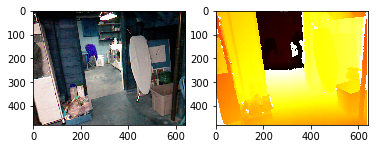

In [53]:
from random import randint
from matplotlib import pyplot as plt

%matplotlib inline

gen = batch_generator(X_filenames, y_filenames)
x, y = next(gen)
print(x.shape)
print(y.shape)

random_index = randint(0, len(x))
fig = plt.figure()
sp = fig.add_subplot(1, 2, 1)
sp.imshow(x[random_index])
sp = fig.add_subplot(1, 2, 2)
sp.imshow(y[random_index], cmap='hot')

In [2]:
input_shape = (None, 304, 228, 3)
x = tf.placeholder(tf.float32, input_shape)
y = tf.placeholder(tf.int32, None)
keep_prob = tf.placeholder(tf.float32)

normalized = tf.div(tf.subtract(x, 128), 255)

fine1 = pool(conv_layer(normalized, [9, 9, 3, 63], strides=[1, 2, 2, 1], name="fine1"))
fine_shape = fine1.get_shape().as_list()

coarse1 = pool(conv_layer(normalized, [11, 11, 3, 96], strides=[1, 4, 4, 1], name="coarse1"))
coarse2 = pool(conv_layer(coarse1, [5, 5, 96, 256], name="coarse2"))
coarse3 = conv_layer(coarse2, [3, 3, 256, 384], name="coarse3")
coarse4 = conv_layer(coarse3, [3, 3, 384, 384], name="coarse4")
coarse5 = tf.nn.dropout(conv_layer(coarse4, [3, 3, 384, 256], name="coarse5"), keep_prob)
coarse6 = tf.nn.dropout(fc_layer(flatten(coarse5), [12800, 4096], name="coarse6"), keep_prob)
coarse7 = fc_layer(coarse6, [4096, (fine_shape[1] * fine_shape[2])], name="coarse7")

reshaped = tf.reshape(coarse7, [-1, fine_shape[1], fine_shape[2], 1], name="reshaped")

fine2 = conv_layer(tf.concat([fine1, reshaped], 3), [5, 5, 64, 64], name="fine2")
fine3 = conv_layer(fine2, [5, 5, 64, 1], name="fine3")

In [4]:
rate = 0.001

EPOCHS = 100
BATCH_SIZE = 1024

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

NameError: name 'logits' is not defined

In [5]:
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_loss += loss
    return (total_loss / num_examples)

ValueError: No variables to save

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})